# EoMT Anomaly Head Evaluation

This notebook is designed to validate the **proposed extension** (Anomaly Head) of the EoMT architecture on benchmark datasets. The primary goal is to test the effectiveness of the new architectures in explicitly predicting anomaly scores compared to traditional post-hoc baselines.

### Execution Notes
* **Environment:** Run on **Google Colab** (or Kaggle) with **GPU** acceleration enabled.
* **Storage:** Datasets are downloaded from anexternal google drive folder.

In [1]:
!git clone -b fine-tuning_anomaly_head_revised https://github.com/Giacomo-FMJ/MaskArchitectureAnomaly

Cloning into 'MaskArchitectureAnomaly'...
remote: Enumerating objects: 1090, done.
remote: Counting objects: 100% (247/247), done.
remote: Compressing objects: 100% (120/120), done.
remote: Total 1090 (delta 172), reused 142 (delta 121), pack-reused 843 (from 3)
Receiving objects: 100% (1090/1090), 27.60 MiB | 17.01 MiB/s, done.
Resolving deltas: 100% (611/611), done.


In [2]:
%cd ./MaskArchitectureAnomaly/eomt

/content/MaskArchitectureAnomaly/eomt


In [3]:
%%capture
!pip install lightning

In [4]:
import os
import csv
import yaml
import gdown
import zipfile
import warnings
import requests
import importlib
from tqdm.auto import tqdm
from typing import Iterable, Any

import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import average_precision_score, roc_curve
from dsets.generic_anomaly import GenericAnomalyDataset

import torch
from torch.nn import functional as F
from torch.amp.autocast_mode import autocast

from huggingface_hub import hf_hub_download
from huggingface_hub.utils import RepositoryNotFoundError

from lightning import seed_everything



def fpr_at_95_tpr(scores, labels):
    """
    Calculates the False Positive Rate (FPR) when the True Positive Rate (TPR) is 95%
    """
    fpr, tpr, thresholds = roc_curve(labels, scores)
    if all(tpr < 0.95):
        return 1.0
    # Find the index where TPR is at least 0.95
    idx = np.argmax(tpr >= 0.95)
    return fpr[idx]

def select_device(device_: str) -> torch.device:

    if device_ == "auto":
        if torch.cuda.is_available():
            return torch.device("cuda")
        elif torch.mps.is_available():
            return torch.device("mps")
        else:
            return torch.device("cpu")

    if device_ == "cpu":
        return torch.device("cpu")
    elif device_ == "cuda" and torch.cuda.is_available():
        return torch.device("cuda")
    elif device_ == "mps" and torch.mps.is_available():
        return torch.device("mps")

    print("[WARNING] Device not found or not available. Using CPU.")
    return torch.device("cpu")

def get_eomt_trained_model():
    """
    Downloads the Validation Dataset from the given Google Drive folder link, extracts its contents,
    and performs cleanup and renaming operations if necessary.
    """

    # folder link
    url = "https://drive.google.com/drive/folders/1q2vHUzora2nP52fP50zmoQAykWuwoGav?usp=share_link"

    folder_name = "eomt_trained_model"

    if not os.path.exists(folder_name):
        gdown.download_folder(url, output=folder_name, quiet=True)

    zip_path = os.path.join(folder_name, "Validation_Dataset.zip")

    with zipfile.ZipFile(zip_path, 'r') as zip_obj:
        for file_name in zip_obj.namelist():
            if "macosx" in file_name.lower():
                continue
            zip_obj.extract(file_name, folder_name)

    # fix a typo in the dataset name
    for dirname in os.listdir(os.path.join(folder_name, "Validation_Dataset")):
        if "obsticle" in dirname.lower():
            os.rename(os.path.join(folder_name, "Validation_Dataset", dirname), os.path.join(folder_name, "Validation_Dataset", dirname.replace("Obsticle", "Obstacle")))

def download_trained_model():
    '''

    Downloads the EOMT trained model checkpoint (.ckpt) from Google Drive.

    The function downloads the file from the provided URL using `gdown`
    and saves it locally as 'eomt_model.ckpt' (or preserves the original name
    if desired, but forcing a specific name is usually safer for loading later).

    '''

    url = "https://drive.google.com/file/d/1mWtNfEBbJ0dGu1newtvhNsVpYi3z1-Hg/view?usp=drive_link"
    output_filename = "trained_model.ckpt"

    if not os.path.exists(output_filename):
        print(f"Downloading {output_filename}...")
        gdown.download(url, output=output_filename, quiet=False, fuzzy=True)
    else:
        print(f"{output_filename} already exists. Skipping download.")

download_trained_model()
get_eomt_trained_model()

Downloading...
From (original): https://drive.google.com/uc?id=1mWtNfEBbJ0dGu1newtvhNsVpYi3z1-Hg
From (redirected): https://drive.google.com/uc?id=1mWtNfEBbJ0dGu1newtvhNsVpYi3z1-Hg&confirm=t&uuid=3d5c77c7-4b30-4d93-ac8f-32bb1133e7da
To: /content/MaskArchitectureAnomaly/eomt/trained_model.ckpt
100%|██████████| 382M/382M [00:07<00:00, 51.5MB/s]


In [5]:
seed_everything(0, verbose=False)

device = select_device("auto")
img_idx = 2  # change to the index of the image you want to visualize
config_path = "./configs/dinov2/common/eomt_base_640_ext.yaml"
data_path = "raw_datasets"  # dataset directory

with open(config_path, "r") as f:
    config = yaml.safe_load(f)

def create_mapping(images, ignore_index):
    # Function to visualize cityscapes objects in the target samples
    unique_ids = np.unique(np.concatenate([np.unique(img) for img in images]))
    valid_ids = unique_ids[unique_ids != ignore_index]
    colors = np.array(
        [plt.cm.hsv(i / len(valid_ids))[:3] for i in range(len(valid_ids))]
    )
    mapping = {cid: colors[i] for i, cid in enumerate(valid_ids)}
    mapping[ignore_index] = np.array([0, 0, 0])
    return mapping


In [6]:
warnings.filterwarnings(
    "ignore",
    message=r".*Attribute 'network' is an instance of `nn\.Module` and is already saved during checkpointing.*",
)

img_size = (1024,1024)
num_classes = 19

# Load encoder
encoder_cfg = config["model"]["init_args"]["network"]["init_args"]["encoder"]
encoder_module_name, encoder_class_name = encoder_cfg["class_path"].rsplit(".", 1)
encoder_cls = getattr(importlib.import_module(encoder_module_name), encoder_class_name)
encoder = encoder_cls(img_size=img_size, **encoder_cfg.get("init_args", {}))

# Load network
network_cfg = config["model"]["init_args"]["network"]
network_module_name, network_class_name = network_cfg["class_path"].rsplit(".", 1)
network_cls = getattr(importlib.import_module(network_module_name), network_class_name)
network_kwargs = {k: v for k, v in network_cfg["init_args"].items() if k not in ["encoder", "masked_attn_enabled"]}
network = network_cls(
    masked_attn_enabled=False,
    #num_classes=num_classes,
    encoder=encoder,
    **network_kwargs,
)

# Load Lightning module
lit_module_name, lit_class_name = config["model"]["class_path"].rsplit(".", 1)
lit_cls = getattr(importlib.import_module(lit_module_name), lit_class_name)
model_kwargs = {k: v for k, v in config["model"]["init_args"].items() if k not in ["network","num_classes"]}
if "stuff_classes" in config["data"].get("init_args", {}):
    model_kwargs["stuff_classes"] = config["data"]["init_args"]["stuff_classes"]


model = (
    lit_cls(
        img_size=img_size,
        num_classes=19,
        network=network,
        **model_kwargs,
    )
    .eval()
    .to(device)
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

EoMT_EXT: num_classes = 19


Unfreezing anomaly_head inside network...


In [7]:
def load_pretrained_model(model_,
                          device_,
                          *,
                          config_=None,
                          local_path=None,
                          repo_namespace="tue-mps",
                          hf_filename="pytorch_model.bin",
                          strict=False,
                          map_location=None,
                          ):

    """
    Load a pretrained model with optional configurations and specified parameters.

    This function attempts to load a pretrained model's weights either from a
    local path or from the HuggingFace Hub. If a configuration object with logger
    information is provided, it attempts to locate and download the model from
    the specified HuggingFace repository. If a mismatch in the positional
    embedding shapes between the model and checkpoint is detected, the positional
    embedding in the state dictionary will be ignored. After loading the state
    dictionary, the model is set to evaluation mode and moved to the specified
    device.

    :param model_: The PyTorch model to load the pretrained weights into.
    :param device_: The device to move the model to after loading the weights.
    :param config_: Optional configuration object containing model and logger settings.
    :param local_path: Optional local file path to a pretrained checkpoint.
    :param repo_namespace: Namespace of the HuggingFace Hub repository where the pretrained model is hosted. Defaults to "tue-mps".
    :param hf_filename: Filename of the pretrained model checkpoint in the repository. Defaults to "pytorch_model.bin".
    :param strict: Whether to enforce strict loading of layers into the model. Defaults to False.
    :param map_location: Device mapping location for loading the checkpoint. Defaults to None.
    :return: The model with loaded pretrained weights, set to evaluation mode and moved to the specified device.
    """

    ckpt_path = local_path or None

    if config_:
        name_ = (config_.get("trainer", {})
                .get("logger", {})
                .get("init_args", {})
                .get("name"))

        if name_:
            try:
                ckpt_path = hf_hub_download(
                    repo_id=f"{repo_namespace}/{name_}",
                    filename=hf_filename)
            except RepositoryNotFoundError:
                warnings.warn(f"Pretrained model `{name_}` not found on HuggingFace Hub")
                return model_.eval().to(device_)

    if not ckpt_path:
        warnings.warn("No checkpoint provided or found")
        return model_.eval().to(device_)

    ckpt = torch.load(ckpt_path, map_location=map_location)

    # Lightning .ckpt
    state_dict_ = ckpt["state_dict"] if isinstance(ckpt, dict) and "state_dict" in ckpt else ckpt

    # Drop positional embedding if shape mismatches
    for key in ("network.encoder.backbone.pos_embed", "encoder.backbone.pos_embed"):
        if key in state_dict_ and key in model_.state_dict():
            if state_dict_[key].shape != model_.state_dict()[key].shape:
                del state_dict_[key]

    model_.load_state_dict(state_dict_, strict=strict)
    model_.eval().to(device_)
    return model_

In [8]:
model = load_pretrained_model(
    model,
    device,
    local_path="/content/MaskArchitectureAnomaly/eomt/trained_model.ckpt",  # CHANGE THIS PATH
    map_location=device,
    strict=False)

# **Architecture Evaluation**  <br>
This evaluation directly considers anomaly logits score from the Anomaly Head

The testing pipeline is currently configured to visualize validation results exclusively for the RoadAnomaly21 dataset (index 1).
This behavior is controlled by the `plot_idx` parameter within the `run_all_datasets` function.

In [ ]:
IGNORE_INDEX = 255
debug_index = 1
DEVICE_TYPE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
def infer_semantic_anomaly(img, target): 
    """
    Performs inference using the Anomaly Head.
    Assumes 'model' and 'device' are available in global scope.
    """
    DEVICE_TYPE = "cuda" if torch.cuda.is_available() else "cpu"
    model.eval()
    device = next(model.parameters()).device

    img_input = img.to(device)

    if img_input.dtype.is_floating_point:
        if img_input.max() <= 1.0:
            img_input = (img_input * 255).byte()
        else:
            img_input = img_input.byte()

    with torch.no_grad(), torch.autocast(device_type="cuda", dtype=torch.float16):
        imgs = [img_input]
        img_sizes = [img.shape[-2:] for img in imgs]

        crops, origins = model.window_imgs_semantic(imgs)
        crops = crops.float() / 255.0
        outputs = model.network(crops)

        mask_logits = outputs[0][-1]
        class_logits = outputs[1][-1]

        # Compute Anomaly Score Explicitly
        h_crop, w_crop = crops.shape[-2:]
        anomaly_logits_dense = model.network.compute_anomaly_score(
            mask_logits,
            class_logits,
            (h_crop, w_crop)
        )

        anom_logit_permuted = anomaly_logits_dense.permute(0, 3, 1, 2)
        zeros = torch.zeros_like(anom_logit_permuted)
        crop_logits = torch.cat([zeros, anom_logit_permuted], dim=1)

        logits = model.revert_window_logits_semantic(crop_logits, origins, img_sizes)
        full_probs = F.softmax(logits[0], dim=0)
        anomaly_map = full_probs[1].cpu().float().numpy()

    if isinstance(target, dict):
        target_list = [target]
    else:
        target_list = [target]

    target_tensor = model.to_per_pixel_targets_semantic(target_list, IGNORE_INDEX)[0]
    target_array = target_tensor.cpu().numpy()

    return logits[0], anomaly_map, target_array

def plot_semantic_results(img, pred_map, target_array):
    """
    Plots:
    1. Input Image
    2. Anomaly Heatmap (Prediction)
    3. Ground Truth Mask
    """
    # Normalize image for display
    img_np = img.permute(1, 2, 0).cpu().numpy()
    img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())

    fig, axes = plt.subplots(1, 3, figsize=(15, 5), tight_layout=True)

    # 1. Input
    axes[0].imshow(img_np)
    axes[0].set_title("Input Image")

    # 2. Prediction (Heatmap)
    # Use 'jet' or 'inferno' to visualize score intensity
    im1 = axes[1].imshow(pred_map, cmap="jet", vmin=0, vmax=1)
    axes[1].set_title("Anomaly Score (Prob Class 1)")
    plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

    # 3. Target (Ground Truth)
    # Mask ignore_index for clean visualization
    target_vis = target_array.copy()
    target_vis[target_vis == IGNORE_INDEX] = 0 # Hide void
    axes[2].imshow(target_vis, cmap="gray")
    axes[2].set_title("Ground Truth (White=Anomaly)")

    for ax in axes:
        ax.axis("off")

    plt.show()

In [12]:
def eval_one_dataset(
        *,
        dataset_name: str,
        dataloader: torch.utils.data.DataLoader,
        ignore_index: int = IGNORE_INDEX,
        plot_first: bool = True) -> list[dict[str, Any]]:

    acc_labels: list[np.ndarray] = []
    acc_scores: list[np.ndarray] = []

    for _img, _target in tqdm(dataloader, desc=f"Evaluating {dataset_name:>20s}"):

        if isinstance(_img, torch.Tensor) and _img.dim() == 4:
            _img = _img[0]

        if isinstance(_target, dict):
             _target = {k: (v[0] if isinstance(v, torch.Tensor) else v) for k, v in _target.items()}
        elif isinstance(_target, torch.Tensor) and _target.dim() == 3:
            _target = _target[0]

        _, anomaly_score, gt = infer_semantic_anomaly(_img, _target)
        valid = (gt != ignore_index)
        if not np.any(valid): continue

        y = (gt[valid] == 1).astype(np.uint8)
        score = anomaly_score[valid].astype(np.float32)

        acc_labels.append(y)
        acc_scores.append(score)

        if plot_first:
            plot_semantic_results(_img, anomaly_score, gt)

    if not len(acc_labels):
        print(f"Warning: No valid pixels found for {dataset_name}")
        return []

    y_true = np.concatenate(acc_labels, axis=0)
    y_scores = np.concatenate(acc_scores, axis=0)

    auprc = round(average_precision_score(y_true, y_scores) * 100., 2)
    fpr95 = round(fpr_at_95_tpr(y_scores, y_true) * 100., 2)

    return [{
        "dataset": dataset_name,
        "method": "SupervisedHead",
        "AuPRC": auprc,
        "FPR95": fpr95
    }]

def run_all_datasets(
        *,
        dataset_cfg: list[dict[str, Any]],
        img_size: tuple[int, int],
        batch_size: int,
        num_workers: int,
        out_csv: str) -> str:

    """
    Orchestrates the evaluation over multiple datasets.
    """

    all_rows: list[dict[str, Any]] = []

    plot_idx = [1]
    i = 0
    for ds_cfg in dataset_cfg:
        ds_name = ds_cfg['name']

        # Initialize Dataset
        ds = GenericAnomalyDataset(ds_cfg, img_size=img_size)
        dl = torch.utils.data.DataLoader(ds,
                                       batch_size=batch_size,
                                       num_workers=num_workers)

        # Evaluate
        rows = eval_one_dataset(
            dataset_name=ds_name,
            dataloader=dl,
            ignore_index=IGNORE_INDEX,
            plot_first = (i in plot_idx))

        all_rows.extend(rows)
        i+=1


    # Save to CSV
    os.makedirs(os.path.dirname(out_csv), exist_ok=True)
    with open(out_csv, "w", newline="") as f:
        # Simplified columns
        writer = csv.DictWriter(f, fieldnames=["dataset", "method", "AuPRC", "FPR95"])
        writer.writeheader()
        writer.writerows(all_rows)

    return out_csv

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Evaluating          RoadAnomaly:   0%|          | 0/60 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Evaluating        RoadAnomaly21:   0%|          | 0/10 [00:00<?, ?it/s]

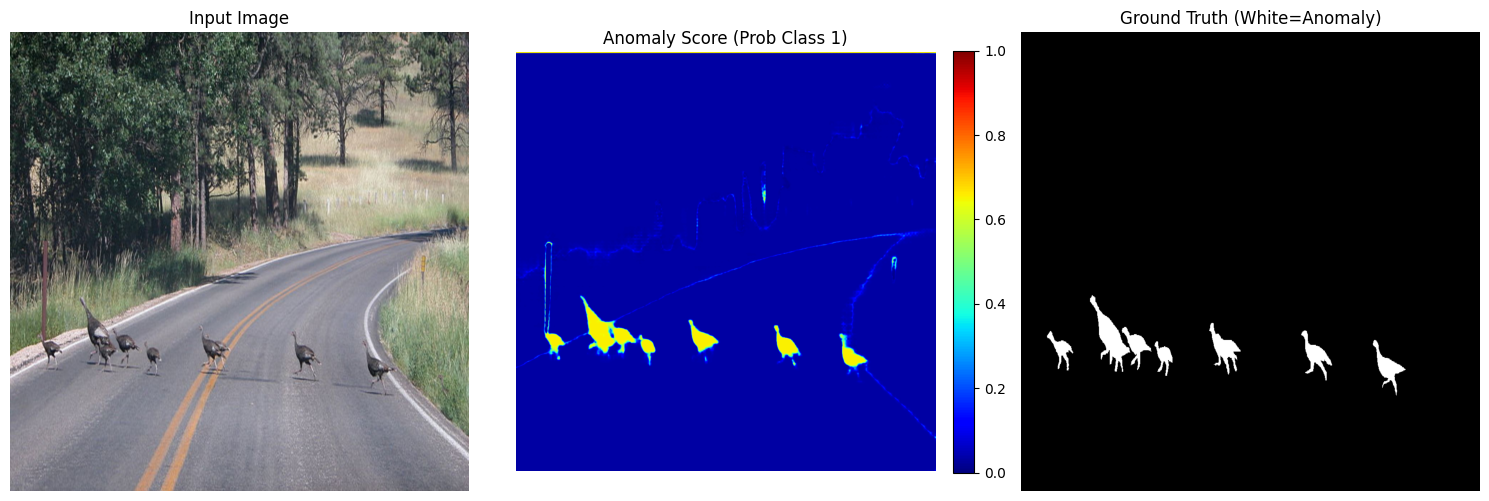

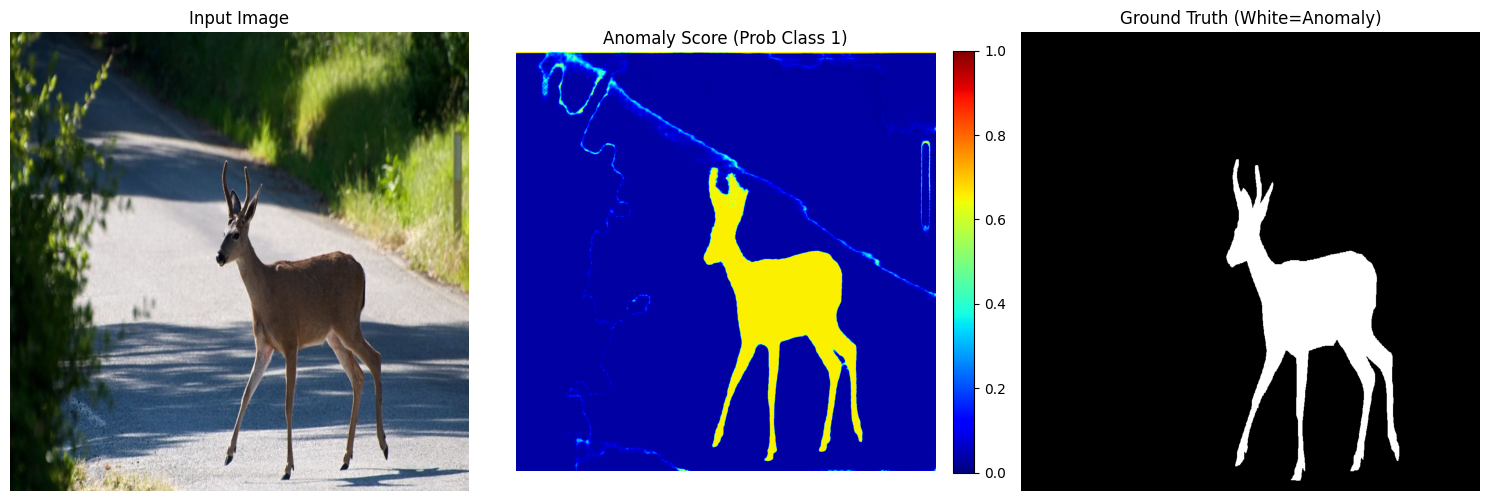

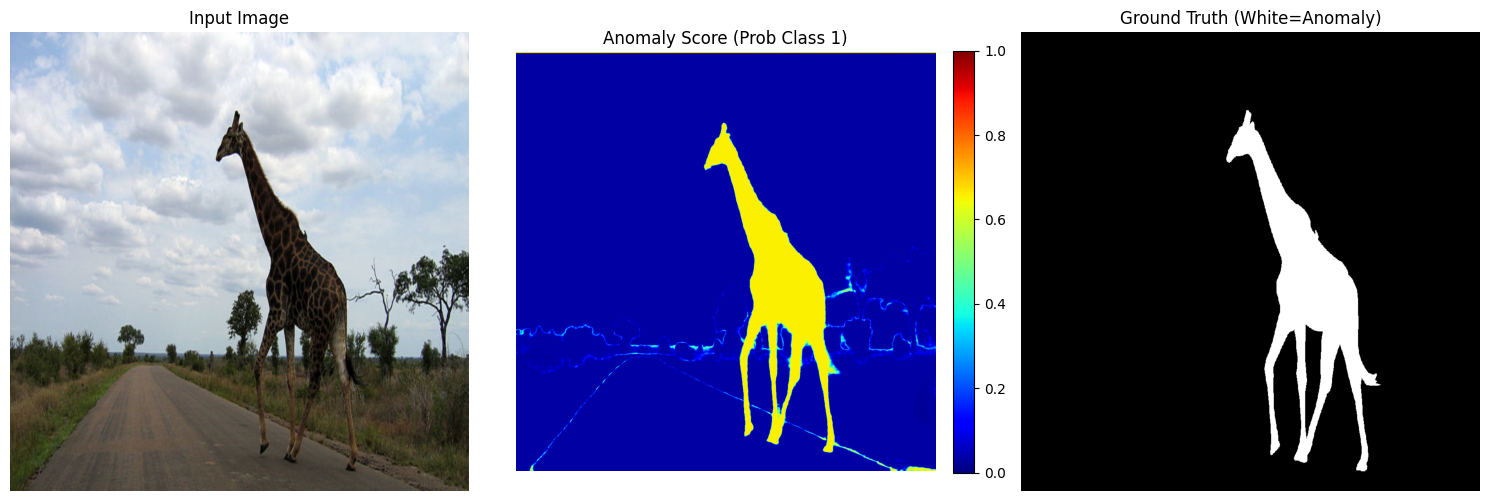

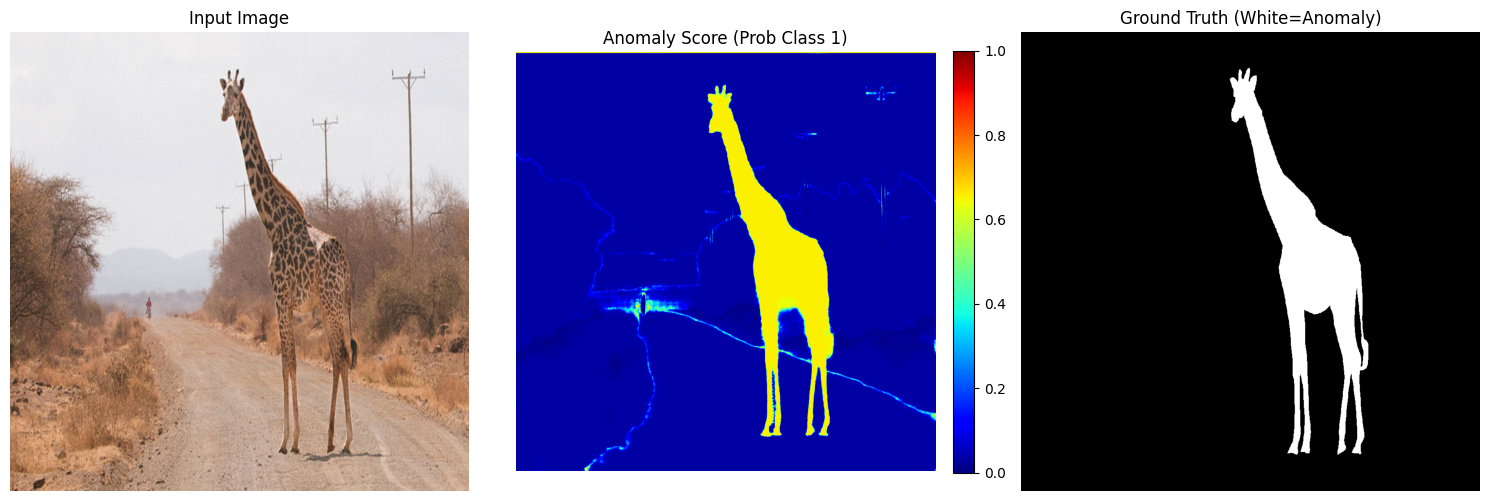

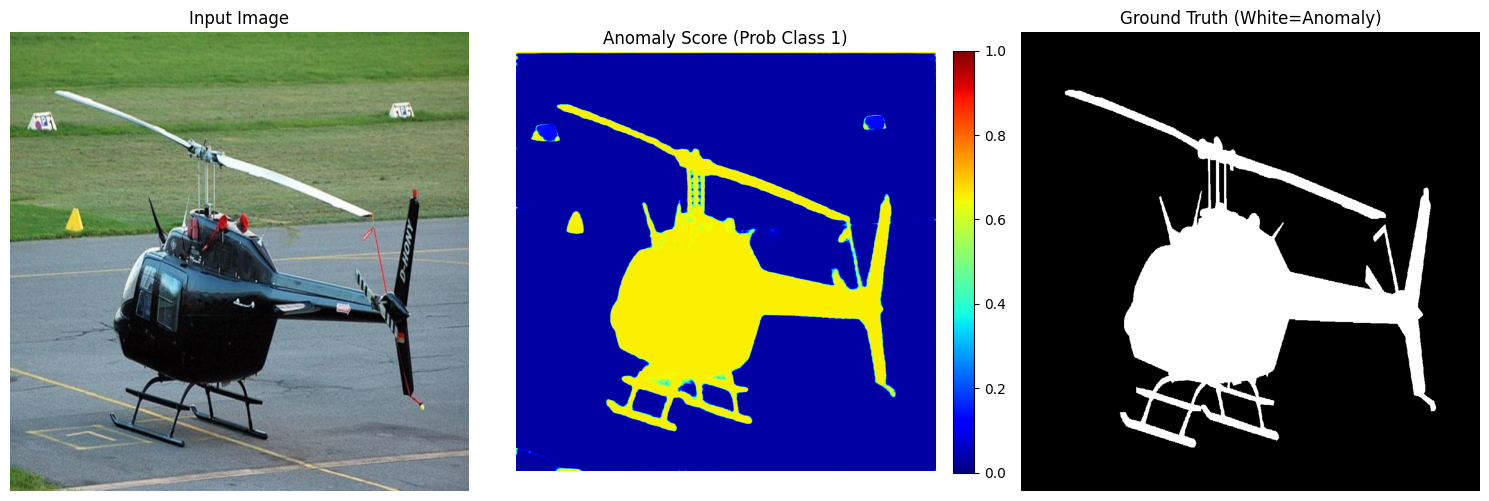

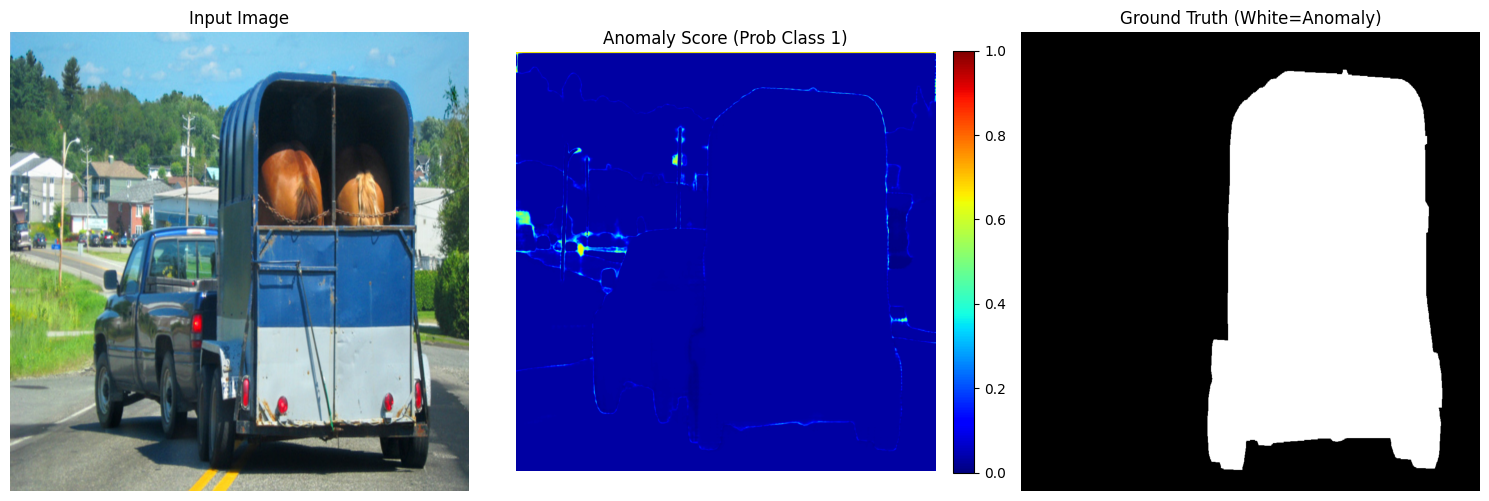

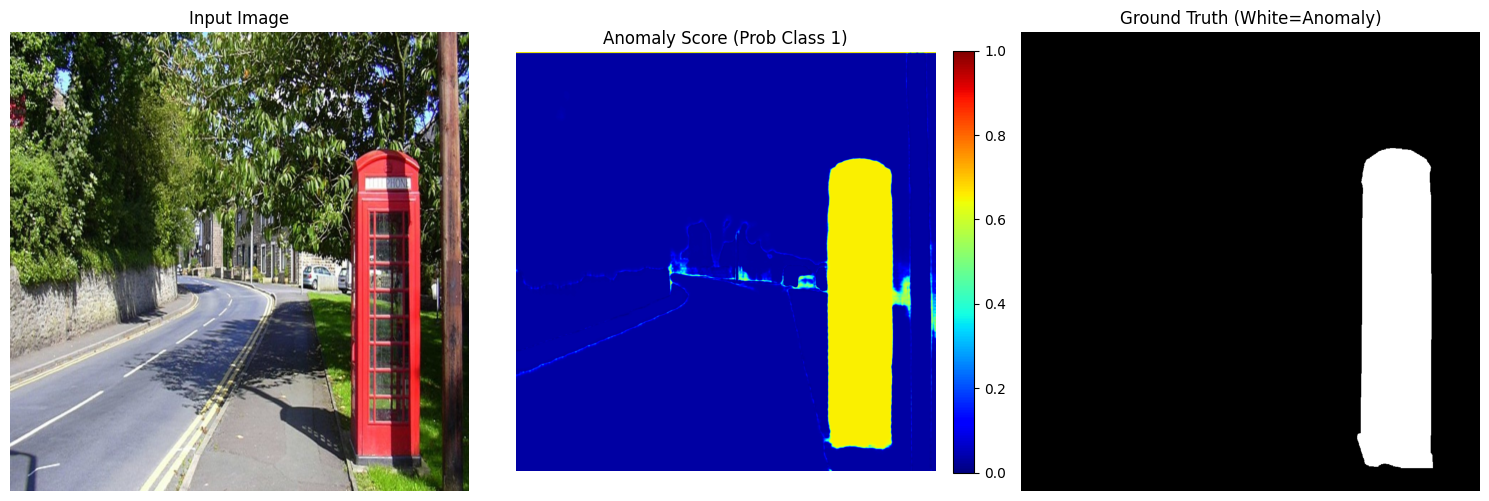

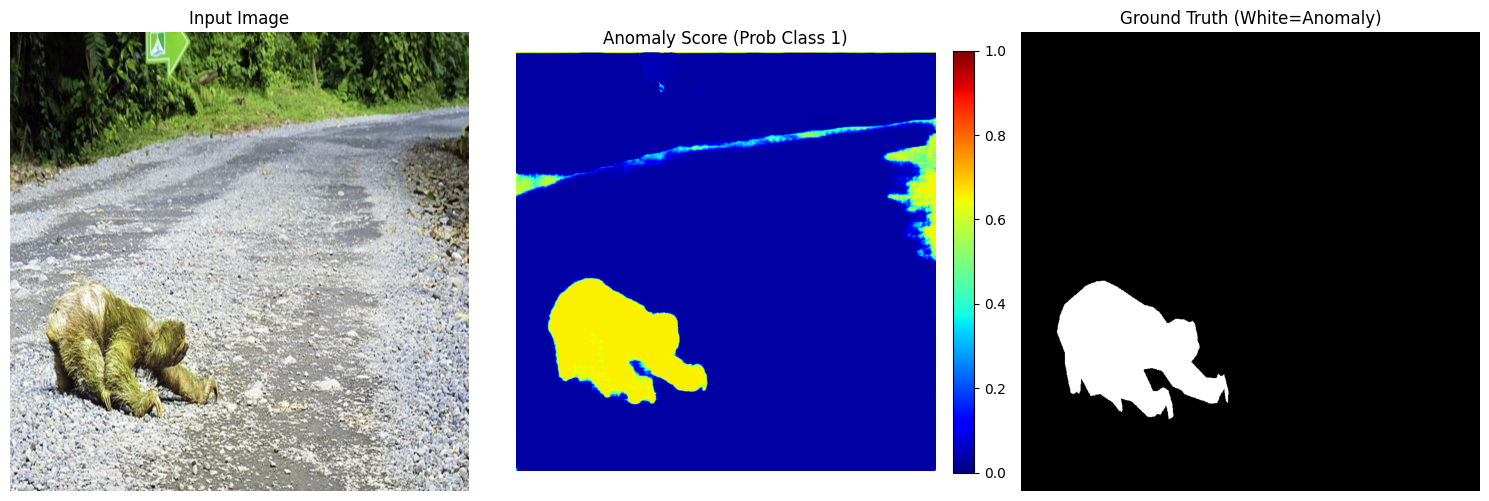

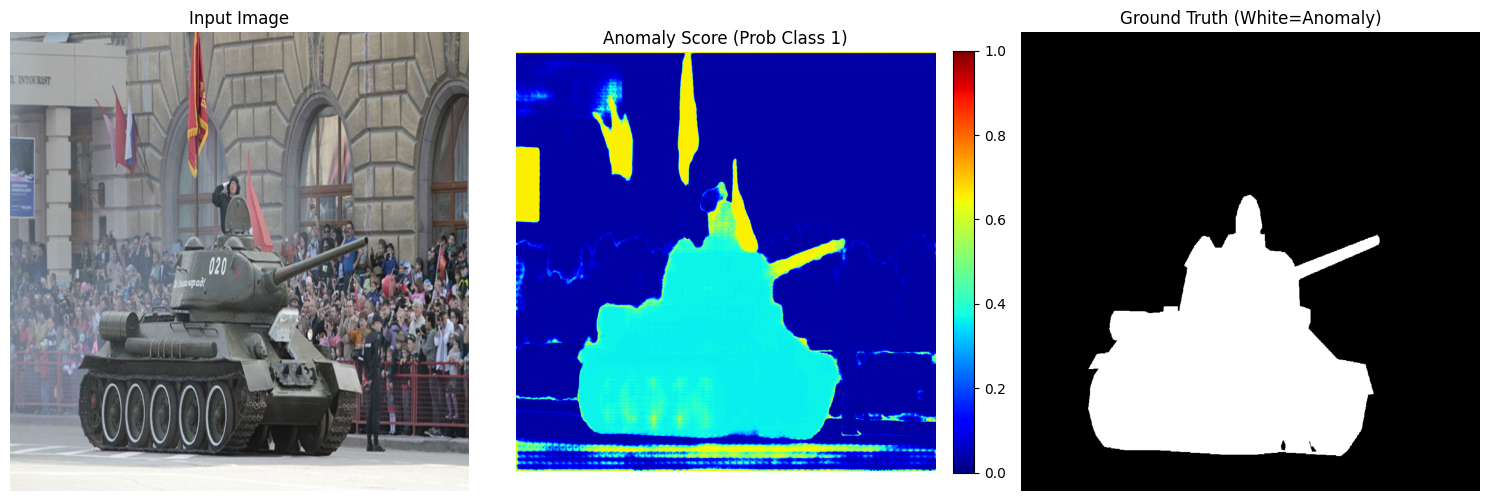

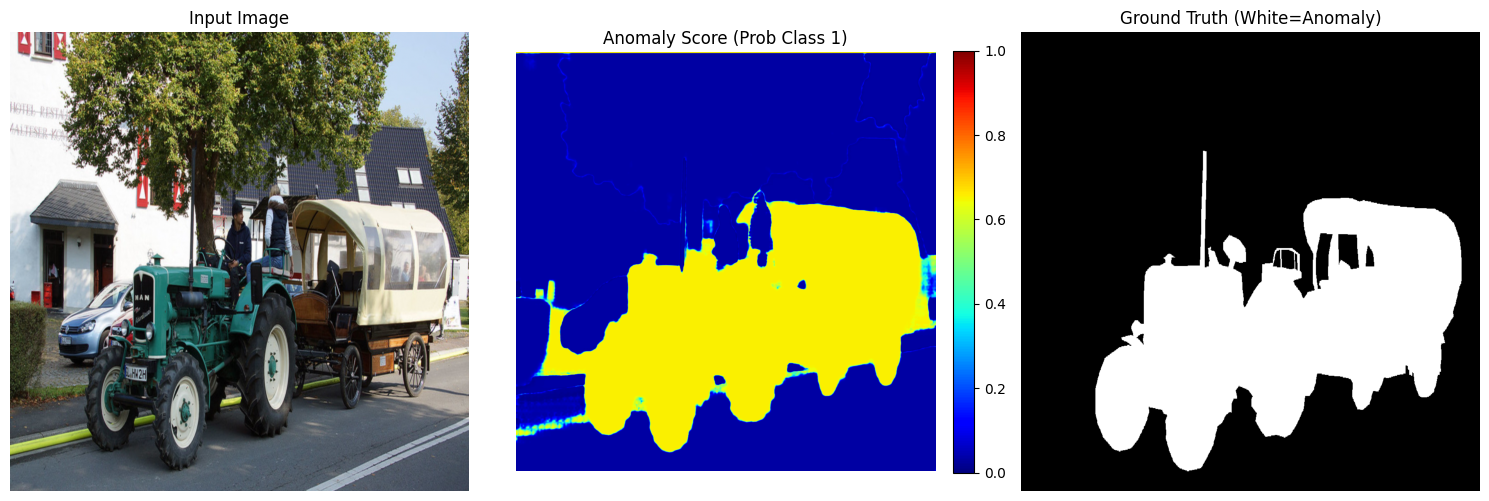

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Evaluating       RoadObstacle21:   0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Evaluating    FS_LostFound_full:   0%|          | 0/100 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c16567a99e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running s

Evaluating            FS_Static:   0%|          | 0/30 [00:00<?, ?it/s]

Evaluation completed. Results saved to: results/table5_anomaly_new.csv


In [13]:
def get_table5_csv():
    # Load configuration
    anomaly_config_path = "/content/MaskArchitectureAnomaly/eomt/configs/dinov2/common/generic_anomaly.yaml"

    with open(anomaly_config_path, "r") as f:
        anomaly_cfg = yaml.safe_load(f)

    # Extract parameters
    datasets_cfg = anomaly_cfg["data"]["init_args"]["datasets"]
    img_size = tuple(anomaly_cfg["data"]["init_args"]["img_size"])
    num_workers = int(anomaly_cfg["data"]["init_args"]["num_workers"])

    # Define output path
    out_csv = "results/table5_anomaly_new.csv"

    # Run Evaluation
    final_csv_path = run_all_datasets(
        dataset_cfg=datasets_cfg,
        img_size=img_size,
        batch_size=1,
        num_workers=num_workers,
        out_csv=out_csv
    )

    print(f"Evaluation completed. Results saved to: {final_csv_path}")

get_table5_csv()